# 과제1: tensorflow를 이용한 NN 밑바닥부터 구현
input feature가 100개이고,  
hidden layer가 2개이고 neuron이 각각 50,10개이고,  
output이 5개인 NN를 구현해 보자  
* hidden layer는 relu를 activation function으로, output layer는 softmax를 activation function으로 사용

In [2]:

import tensorflow as tf
import numpy as np


In [3]:
n_x = 100
n_h1 = 50
n_h2 = 10
n_y = 5

In [4]:
# Simulate train set
m = 500

x_train=np.random.randn(m,n_x).astype(np.float32)
y_train=np.zeros((m,n_y)).astype(np.float32)
y_train[np.arange(m),np.random.randint(n_y,size=m)]=1

print(x_train)
print(y_train)

[[ 0.09292424  1.1226114  -0.14892127 ...  0.35505763 -0.6250185
   0.06406063]
 [-0.19107118 -0.9069979   0.6594785  ... -0.3779809  -0.6777106
  -0.8545593 ]
 [ 0.64288753  0.22239769  0.44552422 ... -1.1086686  -0.512337
   1.9436337 ]
 ...
 [-0.490124   -0.2075825   2.5523329  ...  0.14187047 -0.88157403
  -0.42786354]
 [-1.0634689   0.05400994 -1.0225669  ...  0.98420775 -0.693838
   0.51013905]
 [-1.3775182  -0.4090183   0.9525749  ...  0.29804707  0.7412376
   0.03077603]]
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


* Initialization of weights

In [5]:
w1=tf.Variable(1e-3*np.random.randn(n_x,n_h1).astype(np.float32),name="w1")
## 코드를 작성해 보세요 ##
w2=tf.Variable(1e-3*np.random.randn(n_h1,n_h2).astype(np.float32),name='w2')
w3= tf.Variable(1e-3*np.random.randn(n_h2,n_y).astype(np.float32),name='w3')


* forward propagation을 통해 prediction 값을 구하고, loss를 구하는 function을 만들어 봅시다

In [6]:
def forward(x):
    z1=tf.matmul(x,w1)
    a1=tf.nn.relu(z1)
    ## 코드를 작성해 보세요 ##
    z2=tf.matmul(a1,w2)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(a2,w3)
    predictions = tf.sigmoid(z3)
    
    return predictions

def loss_fn(predictions, y):
    loss= -tf.reduce_sum(y*tf.math.log(predictions))
    return loss    

* backpropagation & update parameters

In [10]:
learning_rate=1e-2
optimizer=tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward(x)
        loss = loss_fn(predictions, y)
    ## 코드를 작성해 보세요 ## (hint: tape.gradient를 구글링 해보세요)
    gradient = tape.gradient(loss,[w1,w2,w3])
    # optimizer와 위에서 구한 경사도를 이용해 가중치들을 업데이트 합니다.
    optimizer.apply_gradients(zip(gradient, [w1, w2,w3]))
    return loss, w1, w2


* 간단하게 train loop를 작성해 loss가 줄어나가는지 확인해 봅시다.

In [12]:
loss_list = []

for step in range(10): 
    loss, w1, w2 = train_step(x_train, y_train)
    loss_list.append(loss.numpy())
    
print(loss_list)

[2.6774156, 1.5584314, 0.91420853, 0.5428622, 0.32769176, 0.20171393, 0.12690982, 0.08173245, 0.053928778, 0.036465935]


# 과제2: MNIST 데이터를 나만의 NN model로 95 % 이상의 성능으로 training 시켜보자!


## Loading MNIST training data

In [3]:
from tensorflow import keras

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling(image data는 min-max scaling 주로 사용)
x_train = x_train/255.0
x_test = x_test/255.0

11493376/11490434 [==============================] - 0s 0us/step


## Training Data
28 * 28 pixel 값을 가진 총 60000개의 이미지 데이터

In [4]:
x_train.shape 

(60000, 28, 28)

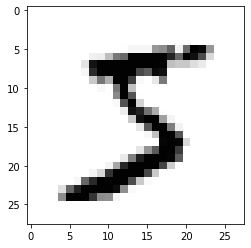

In [5]:
plt.imshow(x_train[0]).set_cmap('Greys')

Neural network 모델에 맞게 이미지 데이터를 벡터 형태로 데이터를 reshape 합니다.  
(Model을 만들 때 *keras.layers.Flatten(input_shape=(28, 28)) 이용해도 됨)

In [6]:
x_train, x_test = x_train.reshape((-1, 28*28)), x_test.reshape((-1, 28*28))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

## Training Labels
이미지 데이터가 나타내는 숫자값을 label로 가지고 있고, 0부터 9까지의 값을 나타냄  
마찬가지로, 60000개의 label이 존재

In [26]:
y_train.shape
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test,10)

In [17]:
# show MNIST label for above data
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## 나만의 모델을 tensorflow keras API 를 이용해 만들어 봅시다~

* parameters for model

In [9]:
activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

#### My Own Model 

In [22]:
#### 자유롭게 Model을 만들고 compile 해봅시다 ####
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256,input_dim=784,activity_regularizer=regularizer, kernel_initializer=initializer_list[0]),
                             tf.keras.layers.Dense(256),
                             tf.keras.layers.Dense(256,activation='tanh'),
                             tf.keras.layers.Dense(10,activation='softmax')
])
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

내가 만든 모델을 확인해 봅시다.

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
_________________________________________________________________


model을 자유롭게 train 해봅시다.  

In [24]:


model.fit(x_train,y_train,epochs=20, batch_size=64)

Epoch 1/20
938/938 [==============================] - 7s 7ms/step - loss: 0.4800 - accuracy: 0.8682
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.2226 - accuracy: 0.9494
Epoch 3/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1858 - accuracy: 0.9588
Epoch 4/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1723 - accuracy: 0.9614
Epoch 5/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1591 - accuracy: 0.9662
Epoch 6/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1466 - accuracy: 0.9692
Epoch 7/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1495 - accuracy: 0.9680
Epoch 8/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1382 - accuracy: 0.9708
Epoch 9/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1384 - accuracy: 0.9712
Epoch 10/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1322 - accuracy: 0.9735

95%이상의 성능을 가진 모델을 만들면 완성!

In [27]:
test_loss, test_acc =  model.evaluate(x_test,y_test, verbose=2)

print('\nAccuracy:', test_acc)

313/313 - 1s - loss: 0.1599 - accuracy: 0.9685

Accuracy: 0.968500018119812


![](https://www.tensorflow.org/versions/master/images/mnist_tensorboard.png)